[課題](https://diver.diveintocode.jp/curriculums/1649)

# Sprint 機械学習スクラッチ クラスタリング

In [1]:
import pandas as pd
import numpy as np
import copy as cy
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, _, test_size=0.25, random_state=0)

In [3]:
X.shape

(100, 2)

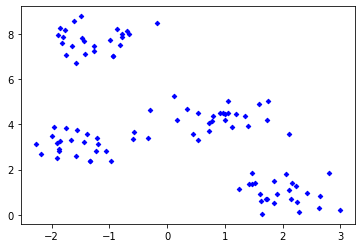

In [4]:
plt.scatter(X[:,0], X[:,1], s=10, c="b", marker="D", label="scatter")

In [5]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def _get_init_mu(self, X, K_count):
        """
        入力データXからK個のμKの初期値を設定する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            入力データ
        K : 次の形の
            μの個数
        """
        N = X.shape[0]

        # 重複なし
        index_mu = np.random.choice(N, size=K_count, replace=False)

        return X[index_mu]
    
    def _assaign_mu(self, X, mu):
        """
        入力データXを最も近い中心点muに割り当てる
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            入力データ
        mu : 次の形のndarray, shape (1, K)
            クラス
        """
        N = X.shape[0]
        K = mu.shape[0]

        # 各クラスに割り当てるための配列
        X_K = [[] for _ in range(K)]

        r = np.zeros(N, dtype=int)

        # 任意のデータに対し、とのクラスに属するか求める
        for i in range(N):
            # 任意のデータと各クラスのμとの距離を求める。temp_disは、shape(1,k)
            temp_dis = [np.linalg.norm(([X[i,0], X[i,1]] - mu[k])) for k in range(K)]

            # 任意のデータと最短距離のμをrとする。
            # このrには、(0:属していない、1:属している)の情報ではなく、
            # どのクラスタに属しているかという情婦が入っている
            r[i] = np.argmin(temp_dis)

        # 任意のデータに対し、各クラスに割り当てる
        for i in range(N):
            X_K[r[i]].append(np.array([X[i,0], X[i,1]]))

        return r, X_K
    
    def _update_mu(self, X_K, mu):
        """
        中心点 μkを k番目のクラスタに割り当てられる全てのデータ点 Xnの平均値（重心）に移動する
        Parameters
        ----------
        X_K : 次の形のndarray, shape (クラス数, クラスに割り当てられたXの数)
            入力データ
        mu : 次の形のndarray, shape (1, K)
            クラス
        """
        K = mu.shape[0]
        mu_new = np.zeros((K, 2))

        # 各クラスに振り分けられたデータの平均値を新しいmuとする
        # mu_new = np.array([np.mean(X_K[k], axis=0) for k in range(K)])
        
        for k in range(K):
            if len(X_K[k]) == 0:
                # 割り当てられていないXがあるクラスは更新しない
                mu_new[k] = mu[k]
            else:
                mu_new[k] = np.array([np.mean(X_K[k], axis=0)])

        return mu_new
    
    def _calc_sse(self, X_K, mu):
        """
        クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する
        Parameters
        ----------
        X_K : 次の形のndarray, shape (クラス数, クラスに割り当てられたXの数)
            入力データ
        mu : 次の形のndarray, shape (1, K)
            クラス
        """
        sse = 0
        K = mu.shape[0]

        for k in range(K):
            if len(X_K[k]) != 0:
                sse = sse + np.sum(np.square(X_K[k] - mu[k]))

        return sse
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # 初期化処理
        n_clusters = self.n_clusters 
        n_init = self.n_init
        max_iter = self.max_iter
        tol = self.tol
        
        sse = 0
        best_sse = 0
        best_mu = 0
        
        for i_count_init in range(n_init):
            # muの初期化
            mu = self._get_init_mu(X, n_clusters)
    
            for i in range(max_iter):
                r, X_K = self._assaign_mu(X, mu)

                prev_mu = mu
                mu = self._update_mu(X_K, mu)
                
                diff = abs(np.mean(mu - prev_mu))
                if diff < tol:
                    break

                # 複数計算した中でSSEが最小になったものが最終的な学習結果とする
                sse = self._calc_sse(X_K, mu)

                if i_count_init == 0:
                    # 初期値初期化の初回時
                    self._best_sse = sse
                    self._best_mu = mu
                else:
                    # 初期値初期化の2回目以降
                    if sse < best_sse:
                        # 中心点 μkを保持
                        self._best_sse = sse
                        self._best_mu = mu

                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print()
    
        return

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        mu = self._best_mu

        r, X_asaign = assaign_mu(X, mu)
        
        # debug
        self._predict_X_K = X_asaign
        
        return r

# 【問題1】中心点の初期値を決める

入力されたデータから K個の中心点 μ1から μKの初期値を決めるコードを作成してください。  
Kは指定したクラスタ数です。  

最もシンプルな初期値の決定方法は、データ点 Xnの中からランダムに K個選ぶことです。  
今回はこれを実装してください。  

K-meansの学習結果は中心点 μの初期値に影響を受けます。  
そのため、学習時には複数個の初期値で計算を行います。  

In [6]:
def get_init_mu(X, K):
    """
    入力データXからK個のμKの初期値を設定する
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        入力データ
    K : 次の形の
        μの個数
    """
    N = X.shape[0]
    
    # 重複なし
    index_mu = np.random.choice(N, size=K, replace=False)
    
    return X[index_mu]

In [7]:
mu = get_init_mu(X, 4)
print(mu)
print(mu[0] in X)
print(mu[1] in X)
print(mu[2] in X)
print(mu[3] in X)

[[ 1.72330962  4.2012082 ]
 [ 1.04829186  5.03092408]
 [-1.37778493  3.58107521]
 [ 1.00952869  4.45502328]]
True
True
True
True


# 【問題2】SSEを求める関数の作成

In [10]:
# 問6で利用されるので問5の後に記述

# 【問題3】クラスタへの割り当て

In [8]:
def assaign_mu(X, mu):
    """
    入力データXを最も近い中心点muに割り当てる
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        入力データ
    mu : 次の形のndarray, shape (1, K)
        クラス
    """

    N = X.shape[0]
    K = mu.shape[0]

    # 各クラスに割り当てるための配列
    X_K = [[] for _ in range(K)]
    
    r = np.zeros(N, dtype=int)

    # 任意のデータに対し、とのクラスに属するか求める
    for i in range(N):
        # 任意のデータと各クラスのμとの距離を求める。temp_disは、shape(1,k)
        temp_dis = [np.linalg.norm(([X[i,0], X[i,1]] - mu[k])) for k in range(K)]
    
        # 任意のデータと最短距離のμをrとする。
        # このrには、(0:属していない、1:属している)の情報ではなく、
        # どのクラスタに属しているかという情婦が入っている
        r[i] = np.argmin(temp_dis)
    
    # 任意のデータに対し、各クラスに割り当てる
    for i in range(N):
        X_K[r[i]].append(np.array([X[i,0], X[i,1]]))

    return r, X_K

In [9]:
K = 4
mu = get_init_mu(X, K)
print("mu",mu[0],mu[1],mu[2], mu[3])
print("X[0]",X[0])

# 1番目 #
temp_dis = [np.linalg.norm(([X[0,0], X[0,1]] - mu[k])) for k in range(K)]
print(temp_dis)
print(np.argmin(temp_dis))

# 100番目 #
print("X[99]",X[-1])
temp_dis = [np.linalg.norm(([X[-1,0], X[-1,1]] - mu[k])) for k in range(K)]
print(temp_dis)
print(np.argmin(temp_dis))

mu [-1.43284669  7.71577043] [-1.74836345  7.06307447] [-1.05327803  2.84037721] [-1.7653772   8.17625727]
X[0] [0.72086751 3.71347124]
[4.5449844541298505, 4.161363158374016, 1.9773430564028758, 5.1086076350168685]
2
X[99] [-0.30022483  4.63059663]
[3.286507214992892, 2.830910438758843, 1.9421572179618116, 3.8364542091103173]
2


In [10]:
r, X_K = assaign_mu(X, mu)
print(r.shape)
print(r)

(100,)
[2 3 2 2 2 2 2 0 1 0 1 1 0 0 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 1 2 2 2 2 3
 2 0 2 2 2 1 2 2 3 2 2 2 2 2 2 2 2 2 0 0 2 2 0 1 2 2 2 2 0 2 2 2 2 3 2 2 0
 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 3 0 2 0 2]


# 【問題4】中心点の移動

中心点 μkを k番目のクラスタに割り当てられる全てのデータ点 Xnの平均値（重心）に移動するコードを作成してください。

クラスタの割り当て rnkを固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

In [11]:
def update_mu(X_K, mu):
    
    K = mu.shape[0]
    mu_new = np.zeros((K, 2))
    
    # 各クラスに振り分けられたデータの平均値を新しいmuとする
    # mu_new = np.array([np.mean(X_K[k], axis=0) for k in range(K)])
    
    for k in range(K):
        if len(X_K[k]) == 0:
            # 割り当てられていないXがあるクラスは更新しない
            mu_new[k] = mu[k]
        else:
            mu_new[k] = np.array([np.mean(X_K[k], axis=0)])
    
    return mu_new

In [12]:
mu = get_init_mu(X, 4)
prev_mu = mu
print(prev_mu)

mu = update_mu(X, mu)
print(mu)

[[ 0.78260667  4.15263595]
 [ 1.7190373   0.71788708]
 [-1.6609057   3.31911046]
 [-1.89928142  2.50466299]]
[[2.21716937 2.21716937]
 [3.03715061 3.03715061]
 [2.86070689 2.86070689]
 [2.77330619 2.77330619]]


# 【問題5】繰り返し

クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。  

次のどれかの条件を満たしたらこれを止めます。  

繰り返しが指定した回数に到達する。（雛形では引数max_iter）  
中心点 μkと重心の差の合計が指定した許容値以下になる。（雛形では引数tol）  

In [13]:
# muの初期値
mu = get_init_mu(X, 4)

max_iter = 10
tol=0.0001 # sklearn参照

for i in range(max_iter):
    r, X_K = assaign_mu(X, mu)
    
    prev_mu = mu
    mu = update_mu(X_K, mu)

    print(mu - prev_mu)
    diff = abs(np.mean(mu - prev_mu))
    print(diff)
    
    if diff < tol:
        break

print(i+1,"回目")

[[ 0.09677348  0.53102584]
 [-1.36936813  1.5736458 ]
 [ 0.48471751  0.00538674]
 [ 0.40276787  0.11122641]]
0.2295219406314358
[[ 0.21940388  0.04532614]
 [-0.16783355  0.32406669]
 [ 0.          0.        ]
 [-0.06276455  0.53117565]]
0.11117178149010191
[[ 0.05793379  0.07742924]
 [-0.20491104  0.34208395]
 [-0.04326787  0.06780905]
 [-0.21382572  0.70928697]]
0.09906729619174978
[[-0.11101485  0.02613889]
 [-0.5868855   0.86012224]
 [-0.04968804  0.20900862]
 [-0.39695538  1.2636024 ]]
0.1517910475049256
[[-0.16632283 -0.14889427]
 [-0.1373208   0.19323949]
 [-0.01976151  0.07516747]
 [-0.22346278  0.32710448]]
0.012531342867862422
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
0.0
6 回目


# 【問題2】SSEを求める関数の作成

クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。  

K-meansはこのSSEを最小化する rnk と μkを求めることが目的となります。  
複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。 

$SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2$

In [14]:
def calc_sse(X_K, mu):
    sse = 0
    K = mu.shape[0]
    
    for k in range(K):
        if len(X_K[k]) == 0:
            # 何もしない
            see = see
        else:
            sse = sse + np.sum(np.square(X_K[k] - mu[k]))
    
    return sse

In [15]:
mu = get_init_mu(X, 4)
r, X_K = assaign_mu(X, mu)
K = 4

sse = calc_sse(X_K, mu)
print(sse)

253.84588884258585


# 【問題6】異なる初期値で計算

問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。
回数は雛形では引数n_initで指定します。

複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 μkを保持しておきます。

In [17]:
# 初期値を変更して計算する
n_init = 100
max_iter = 100
tol=0.0001 # sklearn参照

sse = 0
best_sse = 0
best_mu = 0

for i_count_init in range(n_init):
    # muの初期値
    mu = get_init_mu(X_train, 5)
    #print("初期値")
    #print(mu)

    for i in range(max_iter):
        r, X_K = assaign_mu(X_train, mu)

        prev_mu = mu
        mu = update_mu(X_K, mu)

        #print(mu - prev_mu)
        diff = abs(np.mean(mu - prev_mu))
        #print(diff)

        if diff < tol:
            break
    
    # 複数計算した中でSSEが最小になったものが最終的な学習結果とする
    sse = calc_sse(X_K, mu)
    # print(i+1,"回目","SSE:",sse)
    
    if i_count_init == 0:
        # 初期値初期化の初回時
        #print("初期値")
        best_sse = sse
        best_mu = mu
    else:
        # 初期値初期化の2回目以降
        if sse < best_sse:
            # 中心点 μkを保持
            #print("データ保存")
            best_sse = sse
            best_mu = mu

print("最終結果")
print(best_mu)
print(best_sse)

最終結果
[[-1.40861186  7.32268927]
 [ 0.9590487   4.3136083 ]
 [ 2.06105512  0.8798154 ]
 [-1.5065519   3.06658649]
 [-1.00627225  8.31077922]]
32.59652854711972


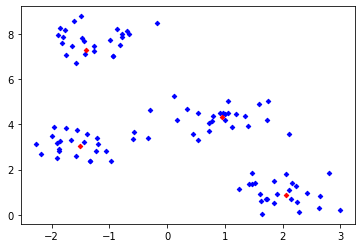

In [18]:
plt.scatter(X[:,0], X[:,1], s=10, c="b", marker="D", label="scatter")
plt.scatter(best_mu[0,0], best_mu[0,1], s=10, c="r", marker="D", label="scatter")
plt.scatter(best_mu[1,0], best_mu[1,1], s=10, c="r", marker="D", label="scatter")
plt.scatter(best_mu[2,0], best_mu[2,1], s=10, c="r", marker="D", label="scatter")
plt.scatter(best_mu[3,0], best_mu[3,1], s=10, c="r", marker="D", label="scatter")

In [20]:
r_best, X_K_best = assaign_mu(X,best_mu)

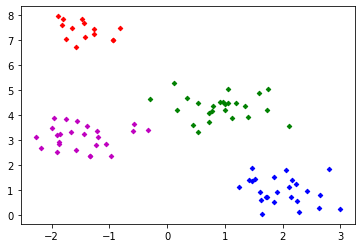

In [21]:
plt.scatter([X_K_best[0][i][0] for i in range(len(X_K_best[0]))], [X_K_best[0][i][1] for i in range(len(X_K_best[0]))], s=10, c="r", marker="D", label="scatter")
plt.scatter([X_K_best[1][i][0] for i in range(len(X_K_best[1]))], [X_K_best[1][i][1] for i in range(len(X_K_best[1]))], s=10, c="g", marker="D", label="scatter")
plt.scatter([X_K_best[2][i][0] for i in range(len(X_K_best[2]))], [X_K_best[2][i][1] for i in range(len(X_K_best[2]))], s=10, c="b", marker="D", label="scatter")
plt.scatter([X_K_best[3][i][0] for i in range(len(X_K_best[1]))], [X_K_best[3][i][1] for i in range(len(X_K_best[3]))], s=10, c="m", marker="D", label="scatter")

# 【問題7】推定

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。  

データ点 Xnと学習で決まった中心点 μk に対し、SSEを最小化する rnk を選ぶ。  

具体的には次のことです。  

データ点 Xnを最も近い μkに割り当てる。    

In [30]:
def predict(X):
    """
    入力されたデータがどのクラスタに属するかを計算
    """
    mu = self._best_mu

    r, X_asaign = assaign_mu(X, mu)
        
    # debug
    self._predict_X_K = X_asaign

    return r

In [31]:
# 学習

clf_sc = ScratchKMeans(n_clusters=4, n_init=100, max_iter=10, tol=0.0001, verbose=False)
clf_sc.fit(X_train)

In [24]:
print(clf_sc._best_mu)

pred_sc = clf_sc.predict(X_test)
print(pred_sc)

[[-1.23920571  7.73872714]
 [ 2.06105512  0.8798154 ]
 [-1.5065519   3.06658649]
 [ 0.9590487   4.3136083 ]]
[2 1 3 0 3 2 1 0 2 0 2 3 1 0 0 1 2 3 1 3 2 1 3 1 0]


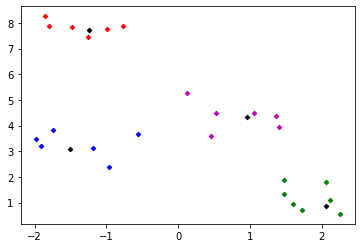

In [25]:
# 推定結果
best_mu = clf_sc._best_mu
plt.scatter(best_mu[0,0], best_mu[0,1], s=10, c="black", marker="D", label="scatter")
plt.scatter(best_mu[1,0], best_mu[1,1], s=10, c="black", marker="D", label="scatter")
plt.scatter(best_mu[2,0], best_mu[2,1], s=10, c="black", marker="D", label="scatter")
plt.scatter(best_mu[3,0], best_mu[3,1], s=10, c="black", marker="D", label="scatter")

X_K_best = clf_sc._predict_X_K
plt.scatter([X_K_best[0][i][0] for i in range(len(X_K_best[0]))], [X_K_best[0][i][1] for i in range(len(X_K_best[0]))], s=10, c="r", marker="D", label="scatter")
plt.scatter([X_K_best[1][i][0] for i in range(len(X_K_best[1]))], [X_K_best[1][i][1] for i in range(len(X_K_best[1]))], s=10, c="g", marker="D", label="scatter")
plt.scatter([X_K_best[2][i][0] for i in range(len(X_K_best[2]))], [X_K_best[2][i][1] for i in range(len(X_K_best[2]))], s=10, c="b", marker="D", label="scatter")
plt.scatter([X_K_best[3][i][0] for i in range(len(X_K_best[3]))], [X_K_best[3][i][1] for i in range(len(X_K_best[3]))], s=10, c="m", marker="D", label="scatter")

# 【問題8】エルボー法の実装

K-meansにおいて中心点の個数 k は人為的に決める必要がありますが、  
その判断方法としてエルボー法があります。エルボー法により中心点の個数 k を検討するためのコードを作成してください。  

SSEを縦軸、クラスタ数 kを横軸にした折れ線グラフを表示します。  
このためにK-meansのインスタンスからはSSEを取得できるようにしてください。 

In [26]:
def plot_elbow(X, k):
    
    count_k = []
    sse = []
    
    for i in range(2, (k+1)):
        clf_sc = ScratchKMeans(n_clusters=i, n_init=100, max_iter=100, tol=0.0001, verbose=False)
        clf_sc.fit(X)
        
        print("クラスタ数:", clf_sc.n_clusters, "SSE:", clf_sc._best_sse)
        
        count_k.append(clf_sc.n_clusters)
        sse.append(clf_sc._best_sse)
    
    plt.plot(count_k, sse)
    plt.title("elbow")
    plt.xlabel("Number of clusters")
    plt.ylabel("Distortion")
    plt.grid(True)
    
    return

クラスタ数: 2 SSE: 273.4421487379078
クラスタ数: 3 SSE: 199.71541335346146
クラスタ数: 4 SSE: 37.86818670452918
クラスタ数: 5 SSE: 35.285940388265395
クラスタ数: 6 SSE: 29.47807045922428
クラスタ数: 7 SSE: 30.13422499249381
クラスタ数: 8 SSE: 23.943939151672936
クラスタ数: 9 SSE: 22.051847834939124
クラスタ数: 10 SSE: 21.979611330103975


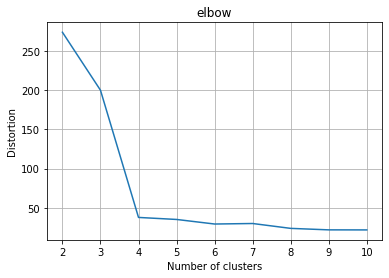

In [32]:
plot_elbow(X_train, 10)

# クラスタ分析

Data Folderの中からWholesale customers data.csvをダウンロードしてください。  
これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。  
中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。  
顧客は小売店やレストランです。  
RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [33]:
df = pd.read_csv("Wholesale_customers_data.csv")

In [34]:
df.head(2)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776


In [35]:
# RegionとChannelは除く
df2 = df.loc[:,['Fresh', 'Milk', "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]]
df2.head(2)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776


In [36]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [258]:
# pd.plotting.scatter_matrix(df2, figsize=(10, 10))
# plt.show()

In [37]:
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
#scaled_data=sc.fit_transform(df2)

scaled_data = np.log2(df2)

df_2_scaled_data=pd.DataFrame(scaled_data,columns=df2.columns)

In [38]:
df_2_scaled_data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12.595513,11.716194,12.178032,10.533687,9.790088,9.615754
std,2.135292,1.560080,1.610295,1.853199,2.482907,1.891130
min,1.584963,5.781360,1.584963,4.643856,1.584963,1.584963
25%,11.610894,10.582141,11.072131,9.535749,8.004218,8.673302
50%,13.053917,11.824558,12.215381,10.575514,9.673296,9.915131
75%,14.047614,12.811825,13.379343,11.795325,11.937350,10.829920
max,16.775083,16.165417,16.501526,15.893420,15.317236,15.549033


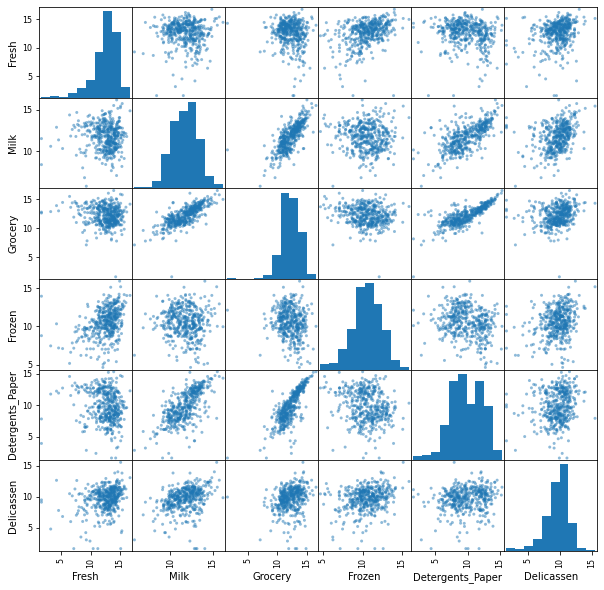

In [39]:
pd.plotting.scatter_matrix(df_2_scaled_data, figsize=(10, 10))
plt.show()

In [40]:
# Tukey法で外れ値を削除
# For each feature find the data points with extreme high or low values
for feature in df_2_scaled_data.keys():
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_2_scaled_data, 25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_2_scaled_data, 75)

    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    print("Data points considered outliers for the feature '{}':".format(feature))
    display(df_2_scaled_data[~((df_2_scaled_data[feature] >= Q1 - step) & (df_2_scaled_data[feature] <= Q3 + step))])
    
# Select the indices for data points you wish to remove
outliers  = [66, 75, 338, 142, 154, 289]

# Remove the outliers, if any were specified
df3 = df_2_scaled_data.drop(df_2_scaled_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,3.169925,10.583083,12.856620,7.451211,11.759888,4.754888
95,1.584963,11.511753,12.610102,8.781360,7.800900,9.469642
96,4.523562,11.353147,12.986909,7.179909,11.919608,7.761551
218,4.169925,12.873444,13.892258,10.327553,12.227917,12.637531
338,1.584963,8.379378,12.777461,13.929351,3.906891,9.103288


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,14.31614,10.151017,1.584963,12.105581,1.584963,9.929258


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
38,12.164593,13.941139,14.028338,5.044394,12.764042,8.758223
65,6.409391,14.355282,15.483942,5.169925,14.564566,10.474720
420,12.121534,12.362492,13.691198,4.643856,12.735133,10.443980


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
75,14.316140,10.151017,1.584963,12.105581,1.584963,9.929258
122,13.576012,7.651052,7.936638,10.959278,4.643856,9.748193
142,15.176641,12.804131,13.010703,11.548340,4.321928,1.584963
154,9.280771,5.781360,7.098032,6.228819,2.807355,3.000000
161,13.602003,9.076816,8.144658,10.092757,1.584963,11.124768
177,13.639228,12.839597,12.146250,10.774787,4.321928,11.361396
204,10.933691,9.799282,12.351491,10.433585,2.321928,10.375039
237,14.190133,11.906139,9.211888,12.178042,4.807355,10.246741
289,15.384851,8.159871,8.879583,10.438792,5.000000,4.459432
338,1.584963,8.379378,12.777461,13.929351,3.906891,9.103288


Data points considered outliers for the feature 'Delicassen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
66,3.169925,10.583083,12.856620,7.451211,11.759888,4.754888
109,10.457381,14.030064,14.823069,9.394463,9.707359,1.584963
128,7.129283,13.110973,11.900489,7.149747,10.052568,1.584963
137,11.591990,12.980140,13.015763,9.368506,9.493855,5.169925
142,15.176641,12.804131,13.010703,11.548340,4.321928,1.584963
154,9.280771,5.781360,7.098032,6.228819,2.807355,3.000000
184,8.353147,9.842350,12.201511,6.209453,8.383704,3.459432
187,11.251482,12.966145,13.261360,12.614020,11.756139,1.584963
203,9.187352,9.419960,11.113742,8.873444,9.897845,4.169925
233,9.912889,12.283088,11.695228,9.871905,8.675957,2.807355


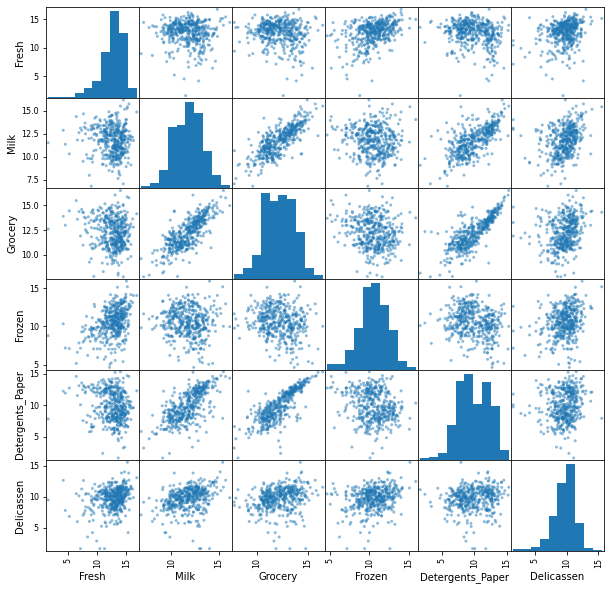

In [41]:
# 外れ値削除後のプロット
pd.plotting.scatter_matrix(df3, figsize=(10, 10))
plt.show()

In [45]:
# 次元削減

from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(df3)
data_pca = pca.transform(df3)

[0.44696778 0.27462924 0.11227818 0.10043625 0.04615921 0.01952934]
[0.44696778 0.72159702 0.8338752  0.93431145 0.98047066 1.        ]


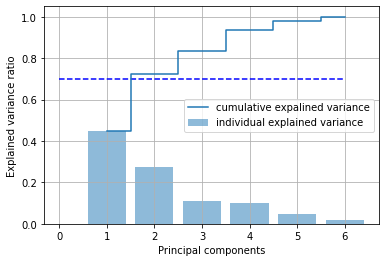

In [46]:
# PCAの分散説明率

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(df3)

var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

print(var_exp)
print(cum_var_exp)

plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

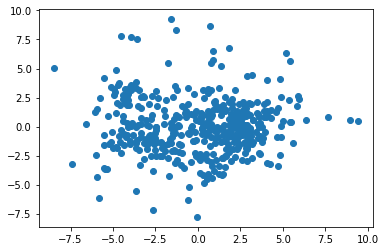

In [47]:
plt.scatter(data_pca[:,0], data_pca[:,1])

# 【問題10】クラスタ数kの選択

最適だと思われるクラスタ数 kを選択してください。  
エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。  
選択した上で、なぜそれを選んだか説明してください。

k = 6とした。  
エルボー法では、分割すればするほど良いと感じた。  
このため、具体的には、何分割すれば良いか判断ができなかった。  
  
ウォード法を利用した。  
ウォード法で確認したところ、大まかに6で分類できそうであると判断したため(主観的)  

In [59]:
# K = 6とする

clf_sc = ScratchKMeans(n_clusters=6, n_init=100, max_iter=10, tol=0.0001, verbose=False)
clf_sc.fit(data_pca)

pred_sc = clf_sc.predict(data_pca)

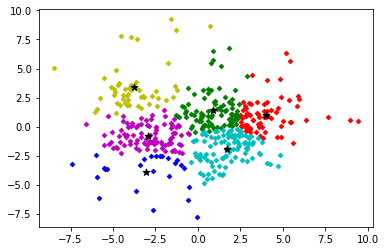

In [64]:
# 推定結果
X_K_best = clf_sc._predict_X_K
plt.scatter([X_K_best[0][i][0] for i in range(len(X_K_best[0]))], [X_K_best[0][i][1] for i in range(len(X_K_best[0]))], s=10, c="b", marker="D", label="scatter")
plt.scatter([X_K_best[1][i][0] for i in range(len(X_K_best[1]))], [X_K_best[1][i][1] for i in range(len(X_K_best[1]))], s=10, c="r", marker="D", label="scatter")
plt.scatter([X_K_best[2][i][0] for i in range(len(X_K_best[2]))], [X_K_best[2][i][1] for i in range(len(X_K_best[2]))], s=10, c="g", marker="D", label="scatter")
plt.scatter([X_K_best[3][i][0] for i in range(len(X_K_best[3]))], [X_K_best[3][i][1] for i in range(len(X_K_best[3]))], s=10, c="y", marker="D", label="scatter")
plt.scatter([X_K_best[4][i][0] for i in range(len(X_K_best[4]))], [X_K_best[4][i][1] for i in range(len(X_K_best[4]))], s=10, c="c", marker="D", label="scatter")
plt.scatter([X_K_best[5][i][0] for i in range(len(X_K_best[5]))], [X_K_best[5][i][1] for i in range(len(X_K_best[5]))], s=10, c="m", marker="D", label="scatter")

best_mu = clf_sc._best_mu
plt.scatter(best_mu[0,0], best_mu[0,1], s=50, c="black", marker="*", label="scatter")
plt.scatter(best_mu[1,0], best_mu[1,1], s=50, c="black", marker="*", label="scatter")
plt.scatter(best_mu[2,0], best_mu[2,1], s=50, c="black", marker="*", label="scatter")
plt.scatter(best_mu[3,0], best_mu[3,1], s=50, c="black", marker="*", label="scatter")
plt.scatter(best_mu[4,0], best_mu[4,1], s=50, c="black", marker="*", label="scatter")
plt.scatter(best_mu[5,0], best_mu[5,1], s=50, c="black", marker="*", label="scatter")


* エルボー法

クラスタ数: 2 SSE: 3644.3838591633994
クラスタ数: 3 SSE: 2764.7678610779662
クラスタ数: 4 SSE: 2247.770688934155
クラスタ数: 5 SSE: 1748.2573831717116
クラスタ数: 6 SSE: 1462.244363716085
クラスタ数: 7 SSE: 1259.079098637102
クラスタ数: 8 SSE: 1122.6552824443966
クラスタ数: 9 SSE: 1016.8331731335068
クラスタ数: 10 SSE: 991.4700341030615
クラスタ数: 11 SSE: 817.546414791169
クラスタ数: 12 SSE: 791.804599090295
クラスタ数: 13 SSE: 710.4828103527459
クラスタ数: 14 SSE: 681.4589090518555
クラスタ数: 15 SSE: 633.1867349899557
クラスタ数: 16 SSE: 601.8794970419586
クラスタ数: 17 SSE: 539.2720779291857
クラスタ数: 18 SSE: 504.25054705148733
クラスタ数: 19 SSE: 525.6445112896959
クラスタ数: 20 SSE: 467.7172594125947


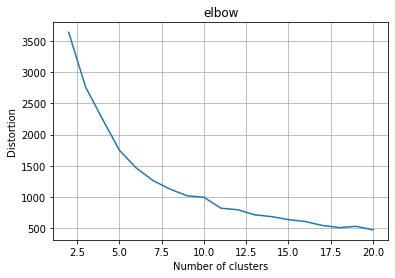

In [49]:
plot_elbow(data_pca, 20)

* 参考

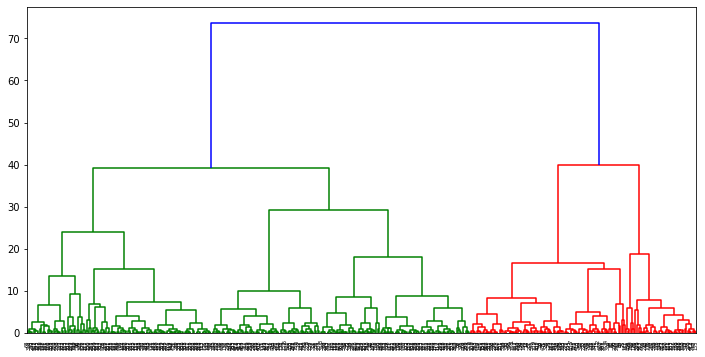

In [51]:
# 階層型クラスタリングに使用する関数インポート
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

# ユークリッド距離とウォード法を使用してクラスタリング
z = linkage(data_pca, metric='euclidean', method='ward')

# 結果を可視化
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
dendrogram(z)
plt.show()

# 【問題11】既知のグループとの比較

RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。  
クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。  

Region  
→この観点は、データが重なっているので分類できないと思われる。  

Channel  
→この観点は、2分割されていることを確認した。  
問題10では、6分割されており、Channelで2分割されたグループは、さらに、それぞれ3分割できると推測する。
  

Region â€“ Lisnon, Oporto or Other (Nominal) Descriptive Statistics:   
→リスボン、ポルト、それ以外  
  
CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)

In [75]:
# Select the indices for data points you wish to remove
outliers  = [66, 75, 338, 142, 154, 289]

df.head
df_region_channel = df.loc[:,["Channel", "Region"]]
df3_region_channel = df_region_channel.drop(df_region_channel.index[outliers]).reset_index(drop = True)

In [85]:
print(data_pca.shape)
print(df3_region_channel.shape)

data_pca_region_channel = np.append(data_pca, df3_region_channel, axis=1)
print(data_pca_region_channel.shape)

(434, 2)
(434, 2)
(434, 4)


1    298
2    142
Name: Channel, dtype: int64
赤:ホテル、レストラン、カフェ, 青:小売店


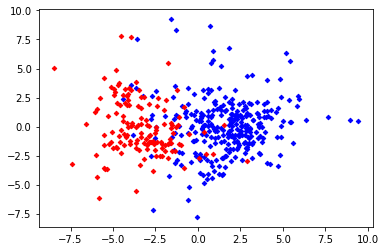

In [131]:
# Channelで分類
print(df_region_channel["Channel"].value_counts())

x1 = data_pca_region_channel[np.where( data_pca_region_channel[:,[2]] == 1 )[0]]
x2 = data_pca_region_channel[np.where( data_pca_region_channel[:,[2]] == 2 )[0]]

print("赤:ホテル、レストラン、カフェ, 青:小売店")

plt.scatter(x1[:,0], x1[:,1], s=10, c="b", marker="D", label="scatter")
plt.scatter(x2[:,0], x2[:,1], s=10, c="r", marker="D", label="scatter")

3    316
1     77
2     47
Name: Region, dtype: int64
青:リスボン, 赤:ポルト, 緑:それ以外


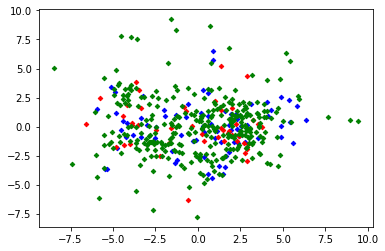

In [130]:
# Channelで分類
print(df_region_channel["Region"].value_counts())

x1 = data_pca_region_channel[np.where( data_pca_region_channel[:,[3]] == 1 )[0]]
x2 = data_pca_region_channel[np.where( data_pca_region_channel[:,[3]] == 2 )[0]]
x3 = data_pca_region_channel[np.where( data_pca_region_channel[:,[3]] == 3 )[0]]

print("青:リスボン, 赤:ポルト, 緑:それ以外")

plt.scatter(x1[:,0], x1[:,1], s=10, c="b", marker="D", label="scatter")
plt.scatter(x2[:,0], x2[:,1], s=10, c="r", marker="D", label="scatter")
plt.scatter(x3[:,0], x3[:,1], s=10, c="g", marker="D", label="scatter")

# 【問題12】卸売業者にとって有益な情報  

卸売業者にとって有益な情報を探し出し文章にまとめてください。

問11の散布図行列より、相関の高い"Milk"と"Grocery"の関係に注目する  

・"Milk"を買う客は"Grocery"も比例して買う。  
・"Channel"1の客(ホテル、レストラン、カフェ)は2の客(小売店)に比べ、多く購入する。  
・"Channel"1の中の客でも、さらに、何らかの要因で2分類できそう。  
・"Channel"2の中の客でも、さらに、何らかの要因で2分類できそう。  

赤:ホテル、レストラン、カフェ, 青:小売店


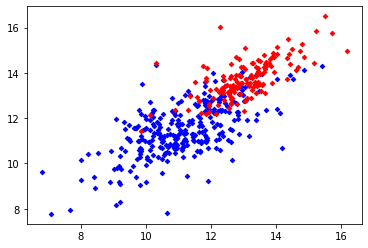

In [184]:
# Channelで分類
index_channel_1 = [np.where( data_pca_region_channel[:,[2]] == 1 )[0]]
index_channel_2 = [np.where( data_pca_region_channel[:,[2]] == 2 )[0]]

print("赤:ホテル、レストラン、カフェ, 青:小売店")

# plt.scatter(df3["Milk"], df3["Grocery"], s=10, c="b", marker="D", label="scatter")
plt.scatter(df3.loc[index_channel_1[0], "Milk"], df3.loc[index_channel_1[0], "Grocery"], s=10, c="b", marker="D", label="scatter")
plt.scatter(df3.loc[index_channel_2[0], "Milk"], df3.loc[index_channel_2[0], "Grocery"], s=10, c="r", marker="D", label="scatter")


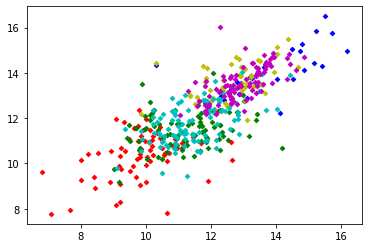

In [182]:
# 問10で分類した結果
index_pred_0 = np.where( pred_sc == 0 )
index_pred_1 = np.where( pred_sc == 1 )
index_pred_2 = np.where( pred_sc == 2 )
index_pred_3 = np.where( pred_sc == 3 )
index_pred_4 = np.where( pred_sc == 4 )
index_pred_5 = np.where( pred_sc == 5 )

plt.scatter(df3.loc[index_pred_0[0], "Milk"], df3.loc[index_pred_0[0], "Grocery"], s=10, c="b", marker="D", label="scatter")
plt.scatter(df3.loc[index_pred_1[0], "Milk"], df3.loc[index_pred_1[0], "Grocery"], s=10, c="r", marker="D", label="scatter")
plt.scatter(df3.loc[index_pred_2[0], "Milk"], df3.loc[index_pred_2[0], "Grocery"], s=10, c="g", marker="D", label="scatter")
plt.scatter(df3.loc[index_pred_3[0], "Milk"], df3.loc[index_pred_3[0], "Grocery"], s=10, c="y", marker="D", label="scatter")
plt.scatter(df3.loc[index_pred_4[0], "Milk"], df3.loc[index_pred_4[0], "Grocery"], s=10, c="c", marker="D", label="scatter")
plt.scatter(df3.loc[index_pred_5[0], "Milk"], df3.loc[index_pred_5[0], "Grocery"], s=10, c="m", marker="D", label="scatter")
